---
title: CST - Class Shape Transformation
subtitle: Theory to Practice - A Tutorial on CST representation.
date: 2025-10-4
bibliography:
  - references.bib
---

Class Shape Transformation (CST) is a classical approach popularly used for parameterizing airfoil
and wing shapes though it is quite general and can also be used to represent other aircraft
components. It uses *class* functions and *shape* functions to parameterize shapes. The *class*
function decides the family of shapes and the *shape* function provides expressivity to fit
different shapes within that class and also the ability to directly control key geometry parameters
such as leading edge radius, trailing edge boattail angle, and closure to a specified aft thickness.
In this tutorial, we walk through the theory behind the CST representation and how to actually use
their `geodiff` implementation in practice.

In [1]:
# Basic Imports
import matplotlib.pyplot as plt
import torch

from geodiff.cst import CST
from geodiff.loss_functions.chamfer import ChamferLoss

from assets.utils import square, normalize_0_to_1

## Theoretical Background
The CST representation works by combining class functions and shape functions. The shape is
represented by the following equations [@kulfan2006fundamental]:
:::{math}
:label: cst_equations
y_u(x) &= C(x) \, S_u(x) + \Delta y_{u} \\
y_l(x) &= C(x) \, S_l(x) - \Delta y_{l}
:::
where, $x \in [0, 1]$. $y_{u}$ and $y_{l}$ are the ordinates of the upper and lower surfaces of the
geometry. $C(x)$ is the class function:
:::{math}
:label: class_function
C(x) = x^{n_1} \left(1 - x \right)^{n_2}
:::
specified by exponents $n_1$ and $n_2$. $S_u(x)$ and $S_l(x)$ are the shape functions for the upper
and lower surfaces described by:
:::{math}
:label: shape_functions
S_u(x) = \sum_{k=0}^{K_u-1} A_{u,k} \, S_k(x), \qquad
S_l(x) = \sum_{k=0}^{K_l-1} A_{l,k} \, S_k(x)
:::
where the element shape functions $S_k(x)$ are the Bernstein basis polynomials
[^Bernstein_polynomial] of degree $n = K - 1$:
$$S_k(x) = \binom{K}{k} x^{k} (1 - x)^{K - k}, \qquad \text{for} \; k = 0, \ldots, K$$

$\Delta y_{u}$ and $\Delta y_{l}$ are trailing-edge offsets that govern the trailing-edge thickness,
specifically:
:::{math}
:label: te_thickness
t_{TE} = \Delta y_{u} + \Delta y_{l}
:::
Note that, we define both quantities to be positive always, this allows us to compute the thickness
at the trailing edge simply as $y_{u} - y_{l}$ since the class function at $x = 1$ vanishes.

[^Bernstein_polynomial]:
    > Bernstein basis polynomials are basis functions that form a partition of unity. The $n + 1$
    > Bernstein basis polynomials of degree $n$ are defined as:
    > $$b_{k, n}(x) = \binom{n}{k} x^{k} (1 - x)^{n - k}, \qquad \text{for} \; k = 0, \ldots, n$$
    > where $\binom{n}{k}$ is a binomial coefficient.
    > 
    > -- [Wikipedia, Bernstein Polynomial](https://en.wikipedia.org/wiki/Bernstein_polynomial)

## Implementation using `geodiff`
We now look at how `geodiff` allows us to easily use the CST parameterization to represent shapes.

The CST class initializer and its expected arguments are shown below:
:::{literalinclude} ../src/geodiff/cst.py
:start-at: __init__
:end-at: -> None
:::

To construct a CST object, we may supply:
- **Class function exponents** `n_1` and `n_2`.
- **Shape function basis count** for the upper and lower surfaces. The degree of the Bernstein
  polynomial used will be one less than the basis count.
- **Trailing edge thicknesses** for the upper and lower surfaces.

### Fitting Shapes
We will use a square as our target geometry. We then use the `ChamferLoss` to compute the geometric
difference loss between the target shape and the shape represented by our CST parameterization.
Since the implementation is written in PyTorch we can use the autograd capabilities to compute the
gradients of the loss w.r.t. the CST shape function coefficients and use an optimizer to modify our
geometry.

We start by obtaining points on our shapes and normalizing them appropriately such that
$x \in [0, 1]$ as assumed by the implementation.

In [2]:
# Get points on a square (curve to fit)
num_pts = 1000
X_square = square(num_pts)

# For CST x values should lie in the range [0, 1]
X_square = normalize_0_to_1(X_square)

We now create a `CST` object by specifying the class function exponents, the basis function counts
and the trailing edge thicknesses.

In [3]:
# Create a CST object
cst = CST(
    n1 = 0.5,
    n2 = 0.5,
    upper_basis_count = 12,
    lower_basis_count = 12,
    upper_te_thickness = 0,
    lower_te_thickness = 0
)

We use the `ChamferLoss` provided by `geodiff` to compute a geometric loss between the target shape
and the shape represented by the `CST` object. PyTorch's autograd capabilities then allow us to
compute gradients of the loss w.r.t. the CST shape function coefficients and modify them to fit the
target shape.

In [4]:
# Train the CST parameters to fit the square
loss_fn = ChamferLoss()

learning_rate = 0.001
epochs = 1000
print_cost_every = 200

Y_train = X_square

optimizer = torch.optim.Adam(cst.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.99)

for epoch in range(epochs):
    Y_model = cst(num_pts = num_pts)
    Y_model = torch.vstack([Y_model[0], Y_model[1]])
    
    loss = loss_fn(Y_model, Y_train)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(loss.item())

    if epoch == 0 or (epoch + 1) % print_cost_every == 0:
        num_digits = len(str(epochs))
        print(f'Epoch: [{epoch + 1:{num_digits}}/{epochs}]. Loss: {loss.item():11.6f}')

Epoch: [   1/1000]. Loss:    0.012038
Epoch: [ 200/1000]. Loss:    0.006183
Epoch: [ 400/1000]. Loss:    0.003808
Epoch: [ 600/1000]. Loss:    0.002843
Epoch: [ 800/1000]. Loss:    0.002256
Epoch: [1000/1000]. Loss:    0.001787


We can now visualize the shape represented by our `CST` object using its `visualize` method.

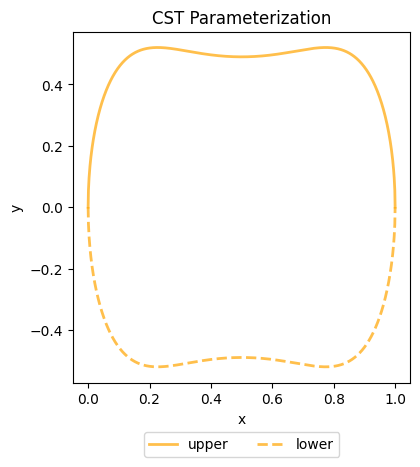

In [5]:
# Visualize the fitted CST shape
fig, ax = cst.visualize(num_pts = num_pts)
plt.tight_layout()
plt.show()